#### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import random
import cv2 as cv

random.seed(42)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
train_path = "train_data/"
test_path = "test_data/"

In [4]:
train_classes = sorted(os.listdir(train_path))

label_map = {i: name for i, name in enumerate(train_classes)}

print(label_map)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


### Visualising Images

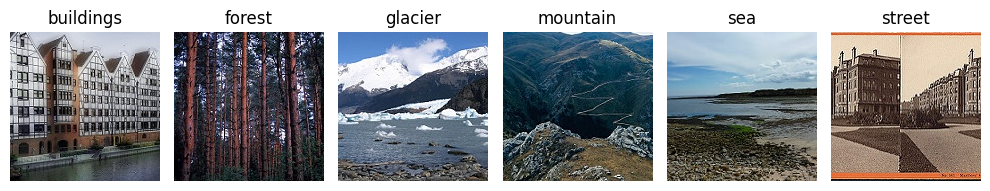

In [5]:
fig, ax = plt.subplots(1, len(train_classes), figsize=(10, 10))

for idx,i in enumerate(train_classes):
    path = os.path.join(train_path, i)
    image = random.choice(os.listdir(path))
    img = os.path.join(path, image)
    
    img = cv.imread(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    ax[idx].imshow(img)
    ax[idx].set_title(i)
    ax[idx].axis('off') 

plt.tight_layout()
plt.show()

#### Preprocessing the Data

In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.images = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]


        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CustomDataset(root_dir = train_path, transform = transform)
test_dataset = CustomDataset(root_dir = test_path, transform = transform)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Building the Neural Network from Scratch

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### Training the Model

In [20]:
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
    train_accuracy = 100*correct_train/total_train
    train_loss = running_loss / len(train_dataloader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}')          

Epoch 1/8, Loss: 0.9679, Accuracy: 63.38
Epoch 2/8, Loss: 0.6633, Accuracy: 76.22
Epoch 3/8, Loss: 0.5394, Accuracy: 81.09
Epoch 4/8, Loss: 0.4391, Accuracy: 84.93
Epoch 5/8, Loss: 0.3645, Accuracy: 87.93
Epoch 6/8, Loss: 0.2910, Accuracy: 90.84
Epoch 7/8, Loss: 0.2308, Accuracy: 93.01
Epoch 8/8, Loss: 0.1733, Accuracy: 95.14


In [21]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():    
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)              
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test  
        
print(f'Accuracy: {100 * correct_test/ total_test:.2f}%')

Accuracy: 79.37%


In [22]:
def predict_model(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    return predicted.item(), confidence.item()

#### Using 25 random images and predicting their classes

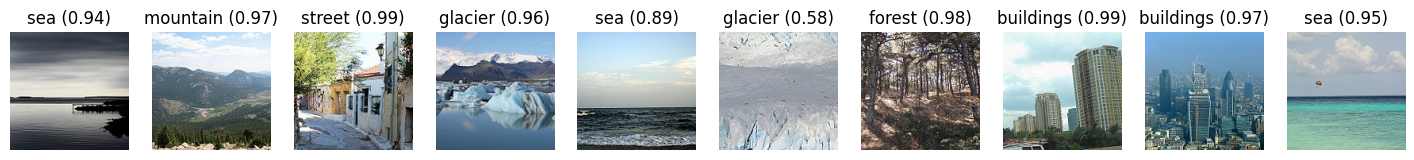

In [23]:
pred_path = 'pred_data/'

images = random.sample(os.listdir(pred_path), 10)

plt.figure(figsize=(18, 6))

for index, img_name in enumerate(images):
    img_path = os.path.join(pred_path, img_name)
    label_index, accuracy = predict_model(img_path)
    label = label_map[label_index]

    img = Image.open(img_path)
    
    plt.subplot(1, 10, index + 1)
    plt.imshow(img)
    plt.title(f'{label} ({accuracy:.2f})')
    plt.axis('off')

plt.show()